# Libs, Constants and Data Loading

In [1]:
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
from datetime import datetime
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
from statsmodels.tsa.arima.model import ARIMA
from sklearn.model_selection import train_test_split, GroupKFold
from sklearn.metrics import root_mean_squared_error
from xgboost import XGBRegressor

import seaborn as sns

plt.style.use('seaborn-v0_8')

In [2]:
TRAIN_DATA_PATH = Path.cwd().parents[0] / 'Data/train.csv'
TEST_DATA_PATH = Path.cwd().parents[0] / 'Data/test.csv'
SUBMISSION_PATH = Path.cwd().parents[0] / 'submissions'

In [3]:
train_raw_data = pd.read_csv(TRAIN_DATA_PATH)
test_raw_data = pd.read_csv(TEST_DATA_PATH)

raw_dataset = pd.concat([train_raw_data, test_raw_data], axis=0).reset_index(drop=True)
train_index = range(0, train_raw_data.shape[0])
test_index = range(train_raw_data.shape[0], raw_dataset.shape[0])

raw_dataset.head()

C:\Users\Pc\AppData\Local\Temp\ipykernel_18144\4161479602.py:1: DtypeWarning: Columns (435,436,437,438,439,440,441,442,443,444,445,446,447,448,449,450,451,452,453,454,455,456,457,458,459,460,461,462,463,464,465,466,467,468,469,470,471,472,473,474,475,476,477,478,479,480,481,482,483,484,485,486,487,488,489,490,491,492,493,494,495,496,497,498,499,500,501,502,503,504,505,506) have mixed types. Specify dtype option on import or set low_memory=False.
  train_raw_data = pd.read_csv(TRAIN_DATA_PATH)


,id,p_num,time,bg-5:55,bg-5:50,bg-5:45,bg-5:40,bg-5:35,bg-5:30,bg-5:25,...,activity-0:40,activity-0:35,activity-0:30,activity-0:25,activity-0:20,activity-0:15,activity-0:10,activity-0:05,activity-0:00,bg+1:00
0,p01_0,p01,06:10:00,NaN,NaN,9.6,NaN,NaN,9.7,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,13.4
1,p01_1,p01,06:25:00,NaN,NaN,9.7,NaN,NaN,9.2,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12.8
2,p01_2,p01,06:40:00,NaN,NaN,9.2,NaN,NaN,8.7,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,15.5
3,p01_3,p01,06:55:00,NaN,NaN,8.7,NaN,NaN,8.4,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,14.8
4,p01_4,p01,07:10:00,NaN,NaN,8.4,NaN,NaN,8.1,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12.7


There is some kind of daily seasonality in the glucose blood level 

Text(0, 0.5, 'blood glucose (mmol/L)')

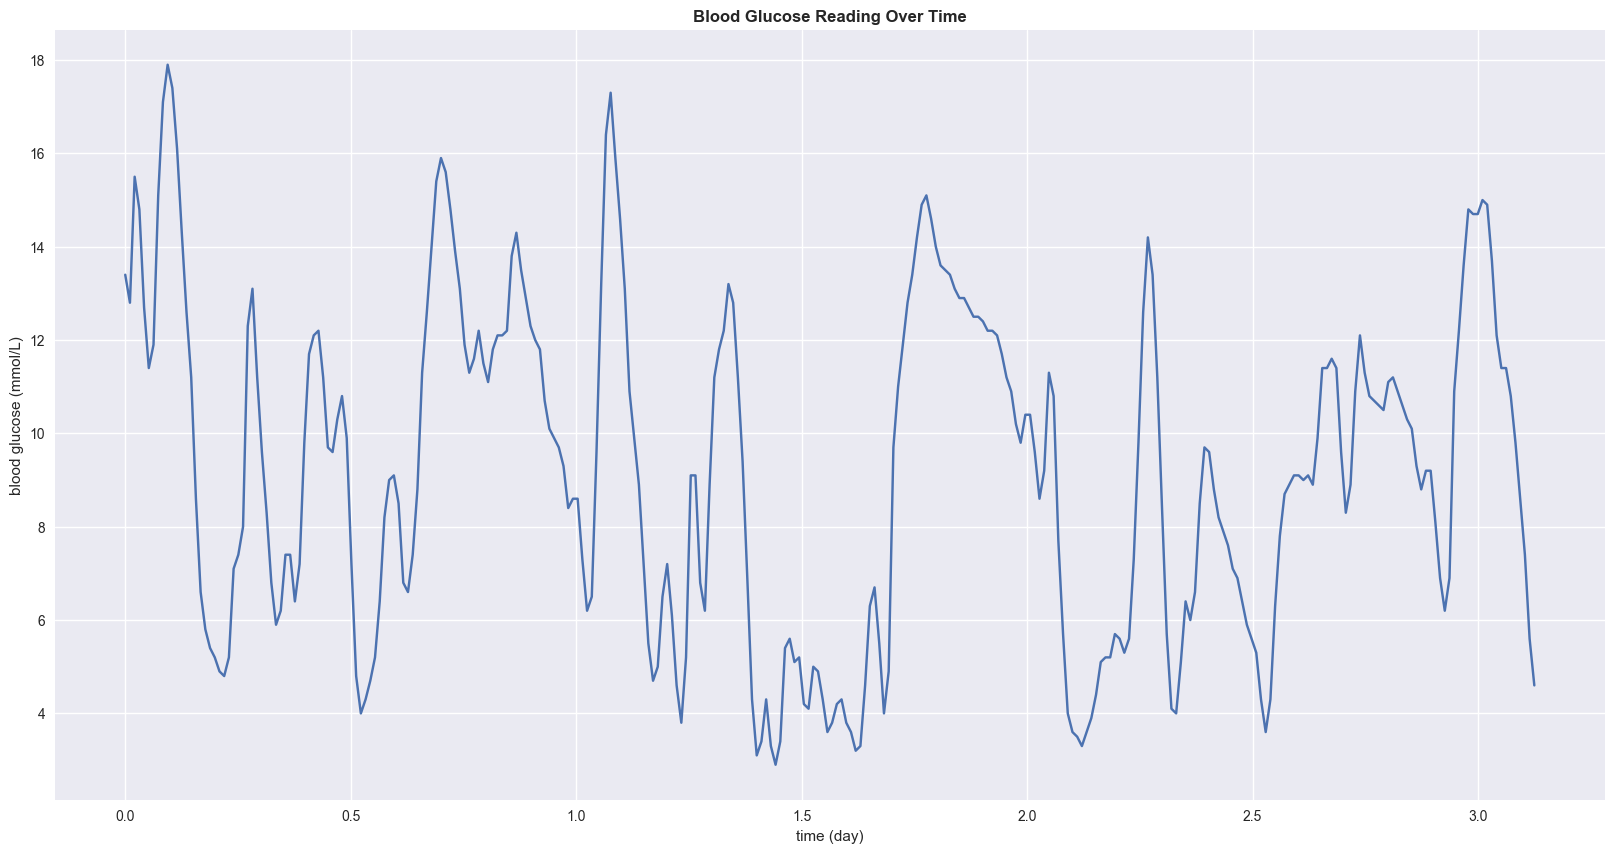

In [5]:
n_elem = 300

x = np.linspace(0,n_elem,n_elem) / 4 / 24
y = raw_dataset[raw_dataset['p_num']=='p01']['bg+1:00'][0:n_elem]

fig, ax = plt.subplots(figsize=(20,10))
ax.plot(x,y)
ax.set_title('Blood Glucose Reading Over Time',fontweight='bold')
ax.set_xlabel('time (day)')
ax.set_ylabel('blood glucose (mmol/L)')

# Transform activities into aerobic and anaerobic score

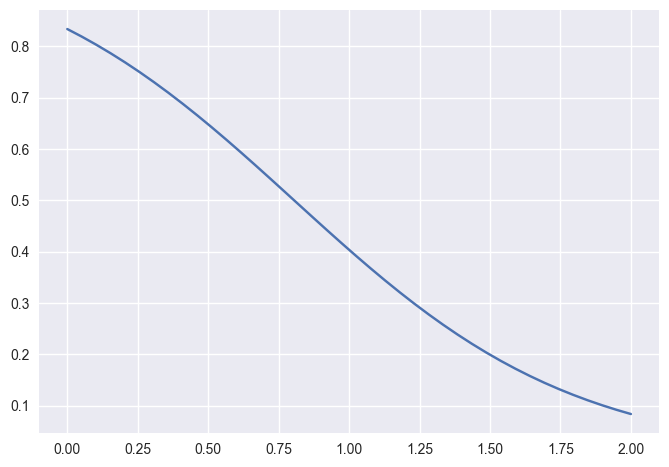

In [4]:
# x: time since current time (hours) for anaerobic exercises
# an_s: time factor for anaerobic activities

x=np.linspace(0,2,40)
an_s = (1-1/(1+5*np.exp(-(x)*2)))

plt.plot(x,an_s)

# anaerobic score: an_s * anf
# where anf is the anaerobic factor and it is a positive number. Anaerobic score represents an increase of glucose level due to anaerobic exersice

def anaerobic_time_function(x):
    return (1-1/(1+5*np.exp(-(x)*2)))

# Note that at x=2 (3 hours before prediction) the influence of anaerobic exersice is canceled

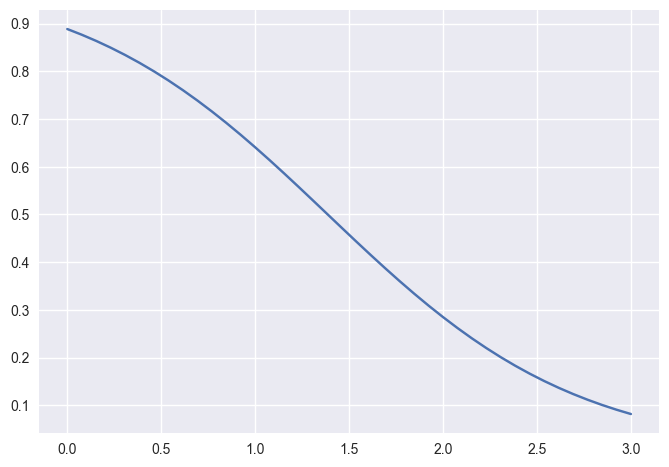

In [5]:
# x: time since current time (hours) for aerobic exercises
# a_s: time factor for aerobic activities

x=np.linspace(0,3,40)
a_s = (1-1/(1+8*np.exp(-(x)*1.5)))

plt.plot(x,a_s)

# aerobic score: a_s * af
# where af is the aerobic factor and it is a positive number. Aerobic score represents a decrease of glucose level due to aerobic exersice

def aerobic_time_function(x):
    return (1-1/(1+8*np.exp(-(x)*1.5)))

# Note that at x=3 (4 hours before prediction) the influence of aerobic exersice is canceled

In [6]:
# dictionaries containing how much aerobic or anaerobic exersices contains each activities (af and anf values)

aerobic_dict = {'Indoor climbing':0,'Run':3,
                         'Strength training':0,'Swim':2,
                         'Bike':3, 'Dancing':1,
                         'Stairclimber':1, 'Spinning':3,
                         'Walking':1,'HIIT':0,
                         'Outdoor Bike':3,'Walk':1,
                         'Aerobic Workout':3,'Tennis':2,
                         'Workout':0,'Hike':1,
                         'Zumba':2,'Sport':2,
                         'Yoga':0,'Swimming':2,
                         'Weights':0,'Running':3}

anaerobic_dict = {'Indoor climbing':2,'Run':0,
                         'Strength training':3,'Swim':0,
                         'Bike':0, 'Dancing':0,
                         'Stairclimber':2, 'Spinning':0,
                         'Walking':0,'HIIT':3,
                         'Outdoor Bike':0,'Walk':0,
                         'Aerobic Workout':0,'Tennis':2,
                         'Workout':3,'Hike':0,
                         'Zumba':0,'Sport':1,
                         'Yoga':0,'Swimming':0,
                         'Weights':3,'Running':0}

In [7]:
columns = list(raw_dataset.columns)
activity_columns = [col for col in columns if re.search(r'activity-.*', col)]

data_with_scores = raw_dataset.copy()

# fill missing values with 0. In most cases, it is logical to assume that the participant did not play sports.
data_with_scores[activity_columns] = data_with_scores[activity_columns].fillna(value=0)

aerobic_scores_dict = {}
anaerobic_scores_dict = {}

for col in activity_columns:

    # get hour from column name
    hour_str = col.split(sep='-')[1]

    hour_obj = datetime.strptime(hour_str, '%H:%M')
    hour = hour_obj.hour + (hour_obj.minute / 60)

    # get aerobic and anaerobic score
    aerobic_scores_dict['A-'+ hour_str] = data_with_scores[col].map(aerobic_dict).astype('float') * aerobic_time_function(hour)
    anaerobic_scores_dict['AN-'+ hour_str] = data_with_scores[col].map(anaerobic_dict).astype('float') * anaerobic_time_function(hour)

# obtain the sums of aerobic and anaerobic scores along time axis
activity_scores_df = pd.concat([pd.DataFrame(aerobic_scores_dict),pd.DataFrame(anaerobic_scores_dict)], axis=1)

aerobic_columns = aerobic_scores_dict.keys()
anaerobic_columns = anaerobic_scores_dict.keys()

sum_aerobic_scores_df = activity_scores_df[aerobic_columns].sum(axis=1).to_frame(name='Aerobic_score')
sum_anaerobic_scores_df = activity_scores_df[anaerobic_columns].sum(axis=1).to_frame(name='Anaerobic_score')

# drop original columns and add the new ones
data_with_scores = data_with_scores.drop(activity_columns, axis=1)
data_with_scores = pd.concat([data_with_scores, sum_aerobic_scores_df, sum_anaerobic_scores_df], axis=1)

data_with_scores

,id,p_num,time,bg-5:55,bg-5:50,bg-5:45,bg-5:40,bg-5:35,bg-5:30,bg-5:25,...,cals-0:30,cals-0:25,cals-0:20,cals-0:15,cals-0:10,cals-0:05,cals-0:00,bg+1:00,Aerobic_score,Anaerobic_score
0,p01_0,p01,06:10:00,NaN,NaN,9.6,NaN,NaN,9.7,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,13.4,0.0,0.0
1,p01_1,p01,06:25:00,NaN,NaN,9.7,NaN,NaN,9.2,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12.8,0.0,0.0
2,p01_2,p01,06:40:00,NaN,NaN,9.2,NaN,NaN,8.7,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,15.5,0.0,0.0
3,p01_3,p01,06:55:00,NaN,NaN,8.7,NaN,NaN,8.4,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,14.8,0.0,0.0
4,p01_4,p01,07:10:00,NaN,NaN,8.4,NaN,NaN,8.1,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12.7,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
180663,p24_256,p24,06:40:00,7.3,7.3,7.1,6.7,6.8,6.8,6.9,...,4.15,4.15,4.23,5.31,4.15,4.15,4.23,NaN,0.0,0.0
180664,p24_257,p24,12:30:00,6.0,6.2,6.2,6.2,5.8,5.5,5.7,...,4.40,4.48,4.31,7.39,6.06,4.31,5.31,NaN,0.0,0.0
180665,p24_258,p24,03:45:00,12.4,12.5,12.7,13.1,13.2,13.3,13.0,...,4.15,4.15,4.15,4.15,4.15,4.15,4.15,NaN,0.0,0.0
180666,p24_259,p24,06:10:00,8.3,8.3,8.2,8.2,7.8,7.4,6.9,...,4.15,4.15,4.15,4.15,4.15,4.15,4.15,NaN,0.0,0.0


# Reduce Time Window

In [8]:
time_window = 4 # Number of past hours taken into account to predict blood glucose levels in +1:00 h
time_len = 3 # Size of 5 minutes window vector used to compute the mean in order to reduce dimensionality. If time_len = n then each column now represents a window of (5*n) minutes

reduced_data = data_with_scores.copy()

columns = list(reduced_data.columns)
column_filter = fr'-[{time_window}-9]:[0-9].*'

# Delete columns older than (time_window) h
delete_columns = [col for col in columns if re.search(column_filter, col)]
reduced_data = reduced_data.drop(delete_columns, axis=1)

In [12]:
expanded_time_data = reduced_data[['id','p_num','time','bg+1:00','Aerobic_score','Anaerobic_score']].copy()

columns = list(reduced_data.columns)
column_filter = [r'bg-.*',r'insulin-.*',r'carbs-.*',r'hr-.*',r'steps-.*',r'cals-.*']

column_clusters = {}
column_cluster_aux = []

# Get dictionary with column clusters
for filter in column_filter:
    
    column_cluster_aux = [col for col in columns if re.search(filter, col)]
    column_clusters[filter.split('-')[0]] = column_cluster_aux

new_column_clusters = column_clusters.copy()

# Get columns grouped by ("time_len" * 5) minutes intervals 
for key, val in column_clusters.items():

    time_clusters = {}
    time_list_aux = val

    for i in range(len(val) // time_len):

        time_clusters[key+'_'+str(i+1)] = time_list_aux[0:time_len]
        time_list_aux = time_list_aux[time_len:]

    new_column_clusters.update({key : time_clusters})

operation_dict = {'bg' : 'mean','insulin':'sum','carbs':'sum','hr':'mean','steps':'sum','cals':'sum'}

# Define aggrgation functions
def apply_operation(df, operation):

    match operation:

        case 'sum':
            return df.sum(axis=1)

        case 'mean':
            return df.mean(axis=1)

        case _:
            return df.sum(axis=1)

# Apply one operation to each type of column in order to aggregate time window vectors 

reduced_data_dict = {}

for col, new_col_dict in new_column_clusters.items():

    for new_col, time_clust in new_col_dict.items():

        reduced_data_dict[new_col] = apply_operation(reduced_data[time_clust], operation_dict[col])

expanded_time_data = pd.concat([expanded_time_data, pd.DataFrame(reduced_data_dict)], axis=1)

expanded_time_data

,id,p_num,time,bg+1:00,Aerobic_score,Anaerobic_score,bg_1,bg_2,bg_3,bg_4,...,cals_7,cals_8,cals_9,cals_10,cals_11,cals_12,cals_13,cals_14,cals_15,cals_16
0,p01_0,p01,06:10:00,13.4,0.0,0.0,11.100000,11.800000,12.800000,13.900000,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
1,p01_1,p01,06:25:00,12.8,0.0,0.0,11.800000,12.800000,13.900000,14.200000,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2,p01_2,p01,06:40:00,15.5,0.0,0.0,12.800000,13.900000,14.200000,14.200000,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
3,p01_3,p01,06:55:00,14.8,0.0,0.0,13.900000,14.200000,14.200000,15.400000,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
4,p01_4,p01,07:10:00,12.7,0.0,0.0,14.200000,14.200000,15.400000,17.200000,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
180663,p24_256,p24,06:40:00,NaN,0.0,0.0,6.433333,6.000000,5.600000,5.400000,...,12.61,12.53,12.45,12.45,12.69,16.10,12.61,12.45,13.69,12.53
180664,p24_257,p24,12:30:00,NaN,0.0,0.0,6.366667,6.266667,6.066667,5.633333,...,12.61,12.45,12.70,12.95,14.28,15.96,12.62,12.70,16.18,15.68
180665,p24_258,p24,03:45:00,NaN,0.0,0.0,12.300000,11.233333,10.833333,10.400000,...,12.45,12.45,12.45,12.45,12.45,12.45,12.45,12.45,12.45,12.45
180666,p24_259,p24,06:10:00,NaN,0.0,0.0,7.866667,7.700000,7.533333,7.900000,...,12.45,12.45,12.45,12.45,12.45,12.53,12.45,12.45,12.45,12.45


# Fill Missing Values

<Axes: >

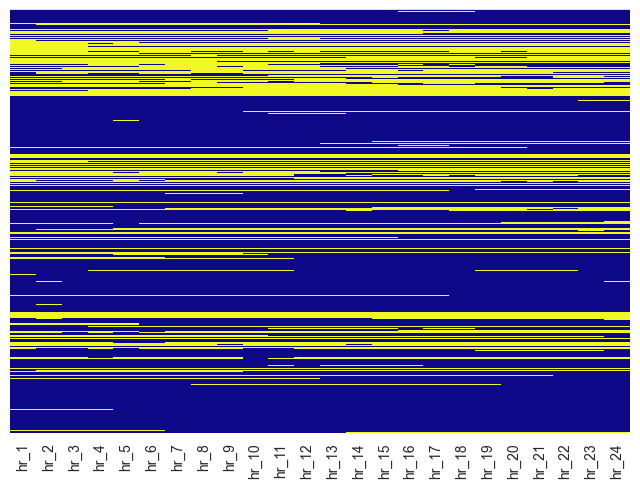

In [ ]:
hr_columns = ['hr_'+str(i) for i in range(1,72 // time_len + 1)]

sns.heatmap(expanded_time_data[hr_columns].isnull(), cbar=False, cmap='plasma', yticklabels=False)

Too many missing values for heart rate. Moreover, this variable may be a bad predictor due to the 1 hour time lag.

In [ ]:
hr_columns = ['hr_'+str(i) for i in range(1,72 // time_len + 1)]
filled_data = expanded_time_data.drop(hr_columns, axis=1)

Fill missing glucose level with average value by person and by time

In [13]:
# Get dataset grouped by person and time
bg_columns = ['bg_'+str(i) for i in range(1,72 // time_len + 1)]
mean_by_per_and_hour = filled_data.groupby(by=['p_num','time'])[bg_columns].mean()

mean_by_per_and_hour

bg_1       bg_2       bg_3       bg_4       bg_5  \
p_num time                                                              
p01   00:00:00   7.365385   7.207692   7.157692   7.346154   7.744000   
      00:05:00   8.586111   8.955556   9.255556   9.325714   9.205882   
      00:10:00   7.424000   7.192000   7.252000   7.468000   7.856000   
      00:15:00   7.200000   7.144000   7.412000   7.808000   8.164000   
      00:20:00   8.940541   9.235135   9.252778   9.202941   8.918919   
...                   ...        ...        ...        ...        ...   
p24   23:25:00  10.200000  10.433333  10.366667   9.866667   9.533333   
      23:35:00  10.433333   9.766667   9.166667   8.233333   7.466667   
      23:40:00   5.766667   4.566667   3.366667   3.800000   5.566667   
      23:50:00   7.566667   6.933333   6.233333   5.933333   5.733333   
      23:55:00  11.833333  12.866667  13.033333  13.766667  13.800000   

                     bg_6       bg_7       bg_8       bg_9      bg_10  ...  \
p_num time                                                             ...   
p01   00:00:00   7.907692   8.053846   8.276923   8.319231   8.119231  ...   
      00:05:00   9.080556   8.855556   8.658333   8.427778   8.297222  ...   
      00:10:00   8.368000   8.980000   9.292000   9.112000   9.056000  ...   
      00:15:00   8.336000   8.576000   8.544000   8.228000   7.812500  ...   
      00:20:00   8.675676   8.491892   8.254054   8.091892   8.094595  ...   
...                   ...        ...        ...        ...        ...  ...   
p24   23:25:00   9.366667   9.300000  10.233333  11.200000        NaN  ...   
      23:35:00   7.633333   7.966667   7.900000   7.933333   8.166667  ...   
      23:40:00   8.200000  10.466667  10.700000   9.966667   8.366667  ...   
      23:50:00   5.400000   5.700000   6.733333   9.166667  10.766667  ...   
      23:55:00  14.066667  14.166667  13.866667  13.400000  12.033333  ...   

                    bg_15      bg_16      bg_17      bg_18      bg_19  \
p_num time                                                              
p01   00:00:00   7.542308   7.588462   7.707692   7.896154   8.276923   
      00:05:00   8.455556   8.327778   8.014286   7.963889   7.702778   
      00:10:00   9.966667  10.075000  10.041667  10.058333  10.112500   
      00:15:00   7.712000   7.872000   8.084000   8.444000   8.492000   
      00:20:00   7.848649   7.508333   7.502703   7.354054   7.313514   
...                   ...        ...        ...        ...        ...   
p24   23:25:00        NaN        NaN        NaN        NaN        NaN   
      23:35:00  12.400000  13.000000  14.033333  14.233333  13.666667   
      23:40:00   3.466667   3.500000   3.866667   5.000000   6.266667   
      23:50:00  14.966667  15.900000  16.066667  14.766667  14.200000   
      23:55:00   6.733333   7.100000   6.633333   6.166667   6.500000   

                    bg_20      bg_21      bg_22      bg_23      bg_24  
p_num time                                                             
p01   00:00:00   8.300000   8.130769   7.973077   7.738462   7.720000  
      00:05:00   7.552778   7.502857   7.685714   7.817143   7.780000  
      00:10:00   9.975000  10.082609  10.130435  10.147826  10.008696  
      00:15:00   8.396000   8.248000   7.964000   7.883333   7.837500  
      00:20:00   7.222222   7.333333   7.508333   7.497222   7.194444  
...                   ...        ...        ...        ...        ...  
p24   23:25:00        NaN        NaN        NaN        NaN        NaN  
      23:35:00  12.166667  10.900000  10.000000   9.233333   9.000000  
      23:40:00   7.933333   9.366667  10.266667  10.700000  10.733333  
      23:50:00  13.366667  11.533333   9.566667  10.433333  12.166667  
      23:55:00   5.533333   5.500000   5.033333   4.866667   5.166667  

[3764 rows x 24 columns]

It seems there are still some missing values

In [14]:
mean_by_per_and_hour.isnull().sum()

bg_1     17
bg_2     17
bg_3     15
bg_4     13
bg_5     15
bg_6     15
bg_7     13
bg_8     14
bg_9     11
bg_10    13
bg_11    13
bg_12    16
bg_13    19
bg_14    20
bg_15    21
bg_16    22
bg_17    26
bg_18    27
bg_19    27
bg_20    25
bg_21    28
bg_22    23
bg_23    21
bg_24    18
dtype: int64

In [15]:
p_nums = mean_by_per_and_hour.index.get_level_values('p_num').unique()

In [16]:
p_null_list = []
for p in p_nums:
    sum_of_nulls = mean_by_per_and_hour.loc[p,:].isnull().sum().sum()

    if sum_of_nulls:
        p_null_list.append(p)

p_null_list

['p15', 'p16', 'p18', 'p19', 'p21', 'p22', 'p24']

Participants with null values are: p15, p16, p18, p19, p21, p22 and p24

The missing values can be obtained by interpolation using other rows. Bellow, there are some functions that will be usefull for interpolation.

In [17]:
def get_null_index_from_list(df, list_of_index):
    '''
    This function is used to get the indixes of a dataframe that have null values from a given list of indexes. It also returns the position of the index in the given list.
    '''

    prov_mask = df.loc[list_of_index,:].isnull().any(axis=1)
    indexes = list(df.loc[list_of_index,:][prov_mask].index)
    position = []

    for time in indexes:
        position.append(list_of_index.index(time))

    return indexes, position

In [18]:
def get_time_indexes(p_num, mean_by_per_and_hour):
    '''
    This function is used to obtain indexes with null values and the rows needed to interpolate those values.
    '''
    # get provisional dataset for a person and get the null index
    person_dataframe = mean_by_per_and_hour.loc[p_num,:].reset_index().sort_values(by='time').copy()
    person_mask = person_dataframe.isnull().any(axis=1)

    null_index = person_dataframe[person_mask].index
    null_time_index = list(person_dataframe.iloc[null_index,:]['time'])

    person_dataframe = person_dataframe.set_index('time')

    # Get adapters to obtain rows bellow and above
    num_index_adapter_1 = np.array(list(null_index))
    num_index_adapter_2 = np.array(list(null_index))

    # In this loop it is checked whether or not rows above or bellow also have null values. If so, then get the next ones
    for i in range(10):

        # Manage when hourly indexes correspond to first hour in the morning or last hour in the evening
        for i in range(len(null_index)):
            if num_index_adapter_1[i] == 0:
                num_index_adapter_1[i] = person_dataframe.shape[0]

            if num_index_adapter_2[i] >= (person_dataframe.shape[0]-1):
                num_index_adapter_2[i] = -1

        # get time index for rows above and bellow
        time_index_above = list(person_dataframe.iloc[num_index_adapter_1-1,:].index)
        time_index_bellow = list(person_dataframe.iloc[num_index_adapter_2+1,:].index)

        # get time index in rows above and bellow that also have null values 
        time_above_null_index, _ = get_null_index_from_list(person_dataframe, time_index_above)
        time_bellow_null_index, _ = get_null_index_from_list(person_dataframe, time_index_bellow)

        # if rows above or bellow also have null values, then get the next one
        if time_above_null_index:
            num_index_adapter_1 += -1

        if time_bellow_null_index:
            num_index_adapter_2 += 1
        
        if not(time_bellow_null_index or time_above_null_index):
            break

    return person_dataframe, null_index, null_time_index, time_index_above, time_index_bellow

Example with one participant

In [19]:
p_num = 'p21'

person_dataframe, null_index, null_time_index, time_index_above, time_index_bellow = get_time_indexes(p_num, mean_by_per_and_hour)

print('Previous times used to interpolate:')
print(time_index_above)
print('\ntimes that have null values:')
print(null_time_index)
print('\nLater times used to interpolate:')
print(time_index_bellow)

Previous times used to interpolate:
['23:45:00', '02:35:00', '02:50:00', '03:05:00', '05:30:00', '06:15:00', '14:30:00', '14:35:00', '14:40:00', '14:45:00', '17:25:00', '18:05:00', '22:20:00', '22:55:00']

times that have null values:
['01:00:00', '03:20:00', '03:35:00', '03:55:00', '06:25:00', '07:55:00', '15:20:00', '15:40:00', '15:45:00', '15:50:00', '18:15:00', '19:30:00', '23:15:00', '23:55:00']

Later times used to interpolate:
['02:00:00', '04:10:00', '04:35:00', '04:50:00', '08:05:00', '08:35:00', '16:35:00', '16:40:00', '16:45:00', '16:50:00', '19:35:00', '20:35:00', '00:35:00', '01:10:00']


In [20]:
def fill_missing_values_by_interpolation(mean_by_per_and_hour, null_time_index, time_index_above, time_index_bellow):
    '''
    This function is used to interpolate missing values from two other rows
    '''
    # fill missing values with a weighted average of rows above and bellow
    for idx, index in enumerate(null_time_index):
    
        # get rows above and bellow
        readings_above = mean_by_per_and_hour.loc[(p_num, (time_index_above[idx])), :].copy()
        readings_bellow = mean_by_per_and_hour.loc[(p_num, (time_index_bellow[idx])), :].copy()

        if readings_above.isnull().sum() > 0 or readings_bellow.isnull().sum() > 0:
            continue

        # get times for each rows
        start_time = datetime.strptime(time_index_above[idx], '%H:%M:%S')
        current_time = datetime.strptime(index, '%H:%M:%S')
        end_time = datetime.strptime(time_index_bellow[idx], '%H:%M:%S')

        start_hour = start_time.hour + start_time.minute / 60
        current_hour = current_time.hour + current_time.minute / 60
        end_hour = end_time.hour + end_time.minute / 60

        # get weights for rows above and below
        time_diff = np.abs(end_hour-start_hour)
        time_above_weight = 1 - np.abs(current_hour-start_hour) / time_diff
        time_bellow_weight = 1 - np.abs(current_hour-end_hour) / time_diff

        # use the weights to interpolate missing values
        weighted_mean_row = time_above_weight * readings_above + time_bellow_weight * readings_bellow
        mean_by_per_and_hour.loc[(p_num, index), :] = mean_by_per_and_hour.loc[(p_num, index), :].fillna(weighted_mean_row)

    return mean_by_per_and_hour

In [21]:
for p_num in p_null_list:
    
    # get rows to use for interpolation
    person_dataframe, null_index, null_time_index, time_index_above, time_index_bellow = get_time_indexes(p_num, mean_by_per_and_hour)

    # fill missing values by interpolation
    fill_missing_values_by_interpolation(mean_by_per_and_hour, null_time_index, time_index_above, time_index_bellow)

mean_by_per_and_hour

bg_1       bg_2       bg_3       bg_4       bg_5  \
p_num time                                                              
p01   00:00:00   7.365385   7.207692   7.157692   7.346154   7.744000   
      00:05:00   8.586111   8.955556   9.255556   9.325714   9.205882   
      00:10:00   7.424000   7.192000   7.252000   7.468000   7.856000   
      00:15:00   7.200000   7.144000   7.412000   7.808000   8.164000   
      00:20:00   8.940541   9.235135   9.252778   9.202941   8.918919   
...                   ...        ...        ...        ...        ...   
p24   23:25:00  10.200000  10.433333  10.366667   9.866667   9.533333   
      23:35:00  10.433333   9.766667   9.166667   8.233333   7.466667   
      23:40:00   5.766667   4.566667   3.366667   3.800000   5.566667   
      23:50:00   7.566667   6.933333   6.233333   5.933333   5.733333   
      23:55:00  11.833333  12.866667  13.033333  13.766667  13.800000   

                     bg_6       bg_7       bg_8       bg_9      bg_10  ...  \
p_num time                                                             ...   
p01   00:00:00   7.907692   8.053846   8.276923   8.319231   8.119231  ...   
      00:05:00   9.080556   8.855556   8.658333   8.427778   8.297222  ...   
      00:10:00   8.368000   8.980000   9.292000   9.112000   9.056000  ...   
      00:15:00   8.336000   8.576000   8.544000   8.228000   7.812500  ...   
      00:20:00   8.675676   8.491892   8.254054   8.091892   8.094595  ...   
...                   ...        ...        ...        ...        ...  ...   
p24   23:25:00   9.366667   9.300000  10.233333  11.200000   8.850000  ...   
      23:35:00   7.633333   7.966667   7.900000   7.933333   8.166667  ...   
      23:40:00   8.200000  10.466667  10.700000   9.966667   8.366667  ...   
      23:50:00   5.400000   5.700000   6.733333   9.166667  10.766667  ...   
      23:55:00  14.066667  14.166667  13.866667  13.400000  12.033333  ...   

                    bg_15      bg_16      bg_17      bg_18      bg_19  \
p_num time                                                              
p01   00:00:00   7.542308   7.588462   7.707692   7.896154   8.276923   
      00:05:00   8.455556   8.327778   8.014286   7.963889   7.702778   
      00:10:00   9.966667  10.075000  10.041667  10.058333  10.112500   
      00:15:00   7.712000   7.872000   8.084000   8.444000   8.492000   
      00:20:00   7.848649   7.508333   7.502703   7.354054   7.313514   
...                   ...        ...        ...        ...        ...   
p24   23:25:00  10.333333  11.033333  12.016667  12.416667  12.066667   
      23:35:00  12.400000  13.000000  14.033333  14.233333  13.666667   
      23:40:00   3.466667   3.500000   3.866667   5.000000   6.266667   
      23:50:00  14.966667  15.900000  16.066667  14.766667  14.200000   
      23:55:00   6.733333   7.100000   6.633333   6.166667   6.500000   

                    bg_20      bg_21      bg_22      bg_23      bg_24  
p_num time                                                             
p01   00:00:00   8.300000   8.130769   7.973077   7.738462   7.720000  
      00:05:00   7.552778   7.502857   7.685714   7.817143   7.780000  
      00:10:00   9.975000  10.082609  10.130435  10.147826  10.008696  
      00:15:00   8.396000   8.248000   7.964000   7.883333   7.837500  
      00:20:00   7.222222   7.333333   7.508333   7.497222   7.194444  
...                   ...        ...        ...        ...        ...  
p24   23:25:00  11.183333  10.000000   8.883333   7.983333   7.666667  
      23:35:00  12.166667  10.900000  10.000000   9.233333   9.000000  
      23:40:00   7.933333   9.366667  10.266667  10.700000  10.733333  
      23:50:00  13.366667  11.533333   9.566667  10.433333  12.166667  
      23:55:00   5.533333   5.500000   5.033333   4.866667   5.166667  

[3764 rows x 24 columns]

Dataframe with average bg by participant and time can be used to impute the missing values of the dataset.

In [22]:
# Impute values
merged_data = filled_data.merge(mean_by_per_and_hour, on=['p_num', 'time'], suffixes=('', '_mean'))
for col in bg_columns:
    filled_data[col] = filled_data[col].fillna(merged_data[col + '_mean'])

The following cell is used to check the hole reduced gb time serie included bg+1:00

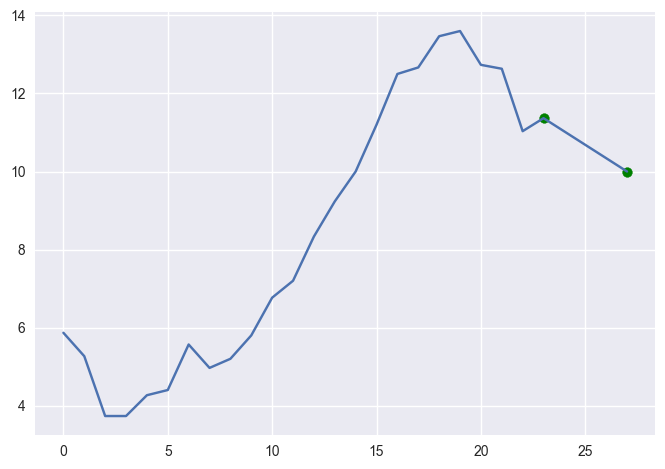

In [16]:
x=np.arange(filled_data[bg_columns].shape[1]+1)
x[-1] = x[-1]+ time_len

sample = filled_data.sample(1)[bg_columns + ['bg+1:00']].values.squeeze()

plt.plot(x, sample)
plt.scatter(x[-2:], sample[-2:], c='g')

# Feature Engineering 

Code the time column by obtaining the total number of minutes elapsed since 12 AM.

In [23]:
filled_data['mins_since_12AM'] = ((pd.to_datetime(filled_data['time'], format='%H:%M:%S') - datetime.strptime('00:00:00', '%H:%M:%S')).dt.total_seconds() / 60).astype('int')

bg_n for n = (72 / time_len) represents the time window from the last 15 minutes to the current time. Next we can add a new column representing the difference between bg_n and the average bg_n by person and time.

In [24]:
filled_data

,id,p_num,time,bg+1:00,Aerobic_score,Anaerobic_score,bg_1,bg_2,bg_3,bg_4,...,cals_16,cals_17,cals_18,cals_19,cals_20,cals_21,cals_22,cals_23,cals_24,mins_since_12AM
0,p01_0,p01,06:10:00,13.4,0.0,0.0,9.600000,9.700000,9.200000,8.700000,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,370
1,p01_1,p01,06:25:00,12.8,0.0,0.0,9.700000,9.200000,8.700000,8.400000,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,385
2,p01_2,p01,06:40:00,15.5,0.0,0.0,9.200000,8.700000,8.400000,8.100000,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,400
3,p01_3,p01,06:55:00,14.8,0.0,0.0,8.700000,8.400000,8.100000,8.300000,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,415
4,p01_4,p01,07:10:00,12.7,0.0,0.0,8.400000,8.100000,8.300000,9.600000,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,430
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
180663,p24_256,p24,06:40:00,NaN,0.0,0.0,7.233333,6.766667,6.866667,6.533333,...,12.53,12.45,12.45,12.69,16.10,12.61,12.45,13.69,12.53,400
180664,p24_257,p24,12:30:00,NaN,0.0,0.0,6.133333,5.833333,5.800000,6.600000,...,12.45,12.70,12.95,14.28,15.96,12.62,12.70,16.18,15.68,750
180665,p24_258,p24,03:45:00,NaN,0.0,0.0,12.533333,13.200000,12.900000,12.933333,...,12.45,12.45,12.45,12.45,12.45,12.45,12.45,12.45,12.45,225
180666,p24_259,p24,06:10:00,NaN,0.0,0.0,8.266667,7.800000,7.000000,7.666667,...,12.45,12.45,12.45,12.45,12.53,12.45,12.45,12.45,12.45,370


In [25]:
filled_data[f'bg_{int(72 / time_len)}'] - merged_data[f'bg_{int(72 / time_len)}_mean']

0         3.882857
1         3.694286
2         3.594286
3         3.438889
4         3.202778
            ...   
180663    0.000000
180664    0.000000
180665    0.000000
180666    0.000000
180667    0.500000
Length: 180668, dtype: float64

In [26]:
merged_data = filled_data.merge(mean_by_per_and_hour, on=['p_num','time'], suffixes=['','_mean'])

filled_data['c_bg_mean_diff'] = filled_data[f'bg_{int(72 / time_len)}'] - merged_data[f'bg_{int(72 / time_len)}_mean']

In [27]:
filled_data

,id,p_num,time,bg+1:00,Aerobic_score,Anaerobic_score,bg_1,bg_2,bg_3,bg_4,...,cals_17,cals_18,cals_19,cals_20,cals_21,cals_22,cals_23,cals_24,mins_since_12AM,c_bg_mean_diff
0,p01_0,p01,06:10:00,13.4,0.0,0.0,9.600000,9.700000,9.200000,8.700000,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,370,3.882857
1,p01_1,p01,06:25:00,12.8,0.0,0.0,9.700000,9.200000,8.700000,8.400000,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,385,3.694286
2,p01_2,p01,06:40:00,15.5,0.0,0.0,9.200000,8.700000,8.400000,8.100000,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,400,3.594286
3,p01_3,p01,06:55:00,14.8,0.0,0.0,8.700000,8.400000,8.100000,8.300000,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,415,3.438889
4,p01_4,p01,07:10:00,12.7,0.0,0.0,8.400000,8.100000,8.300000,9.600000,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,430,3.202778
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
180663,p24_256,p24,06:40:00,NaN,0.0,0.0,7.233333,6.766667,6.866667,6.533333,...,12.45,12.45,12.69,16.10,12.61,12.45,13.69,12.53,400,0.000000
180664,p24_257,p24,12:30:00,NaN,0.0,0.0,6.133333,5.833333,5.800000,6.600000,...,12.70,12.95,14.28,15.96,12.62,12.70,16.18,15.68,750,0.000000
180665,p24_258,p24,03:45:00,NaN,0.0,0.0,12.533333,13.200000,12.900000,12.933333,...,12.45,12.45,12.45,12.45,12.45,12.45,12.45,12.45,225,0.000000
180666,p24_259,p24,06:10:00,NaN,0.0,0.0,8.266667,7.800000,7.000000,7.666667,...,12.45,12.45,12.45,12.53,12.45,12.45,12.45,12.45,370,0.000000


# Training

In [28]:
training_data = filled_data.iloc[train_index,:]
test_data = filled_data.iloc[test_index,:]

In [30]:
gkf = GroupKFold(n_splits=9)

for fold, (_, val_) in enumerate(gkf.split(X=training_data, y=training_data['bg+1:00'], groups=training_data['p_num'])):

    training_data.loc[val_,'fold'] = int(fold)

In [31]:
# Get train and validation datasets
df_train = training_data[training_data['fold'] != fold].reset_index(drop=True)
df_val = training_data[training_data['fold'] == fold].reset_index(drop=True)

X_train = df_train.drop(['id','p_num','time','fold','bg+1:00'], axis=1)
X_val = df_val.drop(['id','p_num','time','fold','bg+1:00'], axis=1)
y_train = df_train['bg+1:00']
y_val = df_val['bg+1:00']

In [32]:
# fit and predict
model = XGBRegressor()

model.fit(X_train, y_train)
predictions = model.predict(X_val)

score = root_mean_squared_error(y_val, predictions)

In [33]:
score

np.float64(2.1966204041808894)

# Full Training

In [ ]:
X_train = training_data.drop(['id','p_num','time','fold','bg+1:00'], axis=1)
y_train = training_data['bg+1:00']
X_test = test_data.drop(['id','p_num','time','bg+1:00'], axis=1)

model = XGBRegressor()

model.fit(X_train, y_train)
predictions = model.predict(X_test)

# Submission

In [43]:
submission_name = 'first_submission.csv'
submission_file = SUBMISSION_PATH / submission_name

In [45]:
ids = test_data['id']

submissions = pd.DataFrame({'id':ids,'bg+1:00':predictions})

submissions.to_csv(submission_file, index=False)